In [40]:
import os
import pickle
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [41]:
# Data paths
case = ''
# case = '_wind_solar'
data_path_taker = 'output_data/btes_base_case_orca{0}_price_taker/btes_output{0}_price_taker_base_BTES_costsx#COST.pickle'.format(case)
data_path_maker = 'output_data/btes_base_case_orca{0}/btes{0}_output_BTES_costsx#COST.pickle'.format(case)

# Prices to scan
prices = ['0p1', '0p25','0p5', '0p75', '0p762', '0p77', '0p9', '1p0'] # 

# Colors
colors = {'price_taker': '#DE3163', 'price_maker': '#00008B'}
color_shades = {'price_taker': ['#f091ac', '#e54573', '#c0063b'], 'price_maker': ['#9c9cea', '#5757d3', '#04049d']}

# Font
font_path = 'Helvetica.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Helvetica'

In [42]:
def get_btes_investment(component_results):
    """
    Get capital expenditure for BTES, i.e. sum of discharge, charge and energy store investment
    """
    btes_investment = 0
    for comp in [('Link','BTES_charger'), ('Link','BTES_discharger'), ('Store','granite')]:
        btes_investment += component_results[component_results.index == comp]['Capital Expenditure [$]'].values[0]
        btes_investment += component_results[component_results.index == comp]['Operational Expenditure [$]'].values[0]
    return btes_investment

In [43]:
def read_output_file(filename):
    """
    Read file results
    """
    with open(filename, 'rb') as f:
        data = pickle.load(f)

        # Get cost from file name
        btes_cost = (filename.split('_')[-1].split('.')[0])

        # Get results from file
        time_inputs = data['time inputs']
        case_data = data['case results']
        comp_results = data['component results']
        time_results = data['time results']

        return time_inputs, case_data, comp_results, time_results, btes_cost
    

In [44]:
def plot_bars_maker_taker(x,y, xlabel, ylabel, title=None, y2=None):
    """
    Plot bar chart for price maker and price taker
    """
    plt.figure()
    # x axis in percent
    x = [int(x*100) for x in x]
    for run,cost in y.items():
        plt.plot(x, cost, 'o', color=colors[run], label=run)
        plt.plot(x, cost, color=colors[run], label=run)
        if y2 is not None:
            plt.plot(x, y2[run], 'o', color=color_shades[run][0], label=f"{run} residence")
            plt.plot(x, y2[run], color=color_shades[run][0], label=f"{run} residence")
            # log scale
            plt.yscale('log')
            # Only set lower limit
            plt.ylim(1, 2*max(y2['price_taker']))
        else:
            plt.ylim(bottom=0)

    # Add horizontal line at 1 if Value added is plotted
    if 'Value added' in ylabel:
        plt.axhline(y=1, color='black', linestyle='dashed')

    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    # Axis tick labels size
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    # Add % to x-axis tick labels
    plt.xticks(ticks=[0, 20, 40, 60, 80, 100], labels=[str(i) + '%' for i in [0, 20, 40, 60, 80, 100]])

    # Save figure
    plt.savefig('figures/btes_{0}{1}.pdf'.format(title.replace(' ','_').replace(',','').lower(), case), bbox_inches='tight', dpi=500)


In [45]:
def plot_curve_maker_taker(var, var2, xlabel, ylabel, ylabel2, color, label, fig=None, ax=None):
    """
    Plot curve for price maker and price taker.
    If fig and ax are provided, adds lines to the existing plot; otherwise, creates a new plot.
    """
    # If no figure and axes are provided, create a new plot
    if fig is None and ax is None:
        fig, ax = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
        # Set labels for new figure
        ax[0].set_ylabel(ylabel, fontsize=14)
        ax[1].set_xlabel(xlabel, fontsize=14)
        ax[1].set_ylabel(ylabel2, fontsize=14)

    # Plot data
    ax[0].plot(var, label=label, color=color)
    
    # Add label to var2 if it exists
    if var2 is not None:
        ax[1].plot(var2, label=label, color='black')
        # ax[1] in log scale
        ax[1].set_yscale('log')

    # Add legend only once for each subplot if it does not exist
    if var2 is not None and not ax[1].get_legend():
        ax[0].legend()

    # Save figure
    if not os.path.exists('figures'):
        os.makedirs('figures')
    plt.savefig(f'figures/btes_energy_in_store_{label}.pdf', bbox_inches='tight')
    
    return fig, ax  # Return fig and ax to reuse in the loop


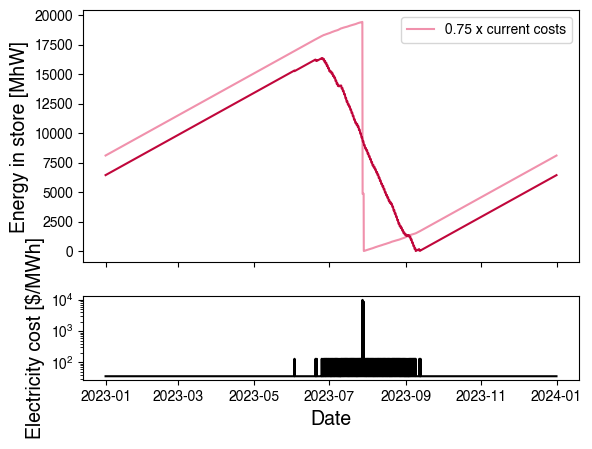

In [46]:
# Collect results
rev_per_inv = {'price_maker': [], 'price_taker': []}
discharge_time = {'price_maker': [], 'price_taker': []}
mean_discharge_time = {'price_maker': [], 'price_taker': []}
inv = {'price_maker': [], 'price_taker': []}
capacity = {'price_maker': [], 'price_taker': []}
capacity_store = {'price_maker': [], 'price_taker': []}
energy_in_store = {'price_maker': [], 'price_taker': []}
gen_capacity = {'price_maker': [], 'price_taker': []}
figure, axis = None, None

# Loop over prices in descending order
for price in prices:
    # Get results
    for run in ['maker', 'taker']:
        time_input, case_res, comp_res, time_res, btes_cost = read_output_file(data_path_maker.replace('#COST', str(price)) if run == 'maker' else data_path_taker.replace('#COST', str(price)))

        # Calculate revenue per investment
        btes_investment = get_btes_investment(comp_res)
        if run =='maker':
            no_btes_file = 'output_data/btes_base_case_orca{0}_no_btes/btes_output{0}_no_btes.pickle'.format(case)
            cost_no_btes = read_output_file(no_btes_file)[1]['objective [$]'].values[-1]
            cost = cost_no_btes - (case_res['objective [$]'].values[-1] - btes_investment)
        else:
            cost = abs(case_res['objective [$]'].values[-1] - btes_investment)
        cost = cost / btes_investment
        rev_per_inv['price_maker' if run == 'maker' else 'price_taker'].append(cost)

        # Calculate discharge_time
        granite = comp_res[comp_res.index == ('Store', 'granite')]
        discharger = comp_res[comp_res.index == ('Link', 'BTES_discharger')]
        charger = comp_res[comp_res.index == ('Link', 'BTES_charger')]

        granite_opt_cap = granite['Optimal Capacity [MW]'].values[0]
        discharger_opt_cap = discharger['Optimal Capacity [MW]'].values[0] 
        dur = granite_opt_cap / discharger_opt_cap

        discharge_time['price_maker' if run == 'maker' else 'price_taker'].append(dur)

        # Calculate mean "discharge time" as mean energy in store divided by mean discharge rate
        mean_discharge_time['price_maker' if run == 'maker' else 'price_taker'].append(time_res['granite e'].mean() / time_res['BTES_discharger dispatch'].mean())

        # Get investment
        inv['price_maker' if run == 'maker' else 'price_taker'].append([discharger['Capital Expenditure [$]'].values[0], charger['Capital Expenditure [$]'].values[0], granite['Capital Expenditure [$]'].values[0]])
        
        # Get energy in store
        # Only plot for price taker for 0.75 and 0.77
        if run == 'taker' and price in ['0p75','0p77']:
            if price == '0p75':
                col = color_shades['price_taker'][0]
            elif price == '0p77':
                col = color_shades['price_taker'][2]
            else:
                col = color_shades['price_taker'][1]
            figure, axis = plot_curve_maker_taker(time_res['granite e'], time_input['const_generator marginal cost'] if price == '0p75' else None,
                                   xlabel='Date', ylabel='Energy in store [MhW]', ylabel2='Electricity cost [$/MWh]',
                                   color=col, label=price.replace('p','.')+' x current costs',
                                    fig=figure, ax=axis)
        
        # Add optimal capacity for all components

        capacity['price_maker' if run == 'maker' else 'price_taker'].append(discharger_opt_cap)

        capacity_store['price_maker' if run == 'maker' else 'price_taker'].append(granite_opt_cap)

        capacities = comp_res[~comp_res.index.get_level_values(0).isin(['Load', 'Store'])]['Optimal Capacity [MW]']
        # Drop level 0 of index
        capacities.index = capacities.index.droplevel(0)
        gen_capacity['price_maker' if run == 'maker' else 'price_taker'].append(capacities)




In [47]:
print(discharge_time)

{'price_maker': [469.4857446729526, 451.3814096509692, 410.1416045995335, 341.2522474971332, 337.54961903997, 369.2945967028964, 529.9243864537156, 570.4382482870061], 'price_taker': [3.994530763702376, 3.994530763702376, 3.994530763702376, 3.994530763702376, 599.9778717470209, 599.9778717470209, 599.9778717470209, 599.9778717470209]}


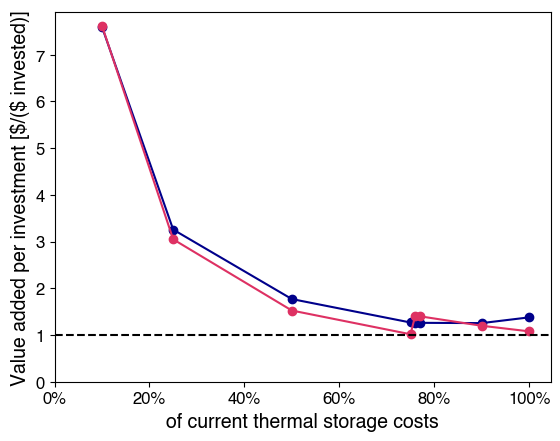

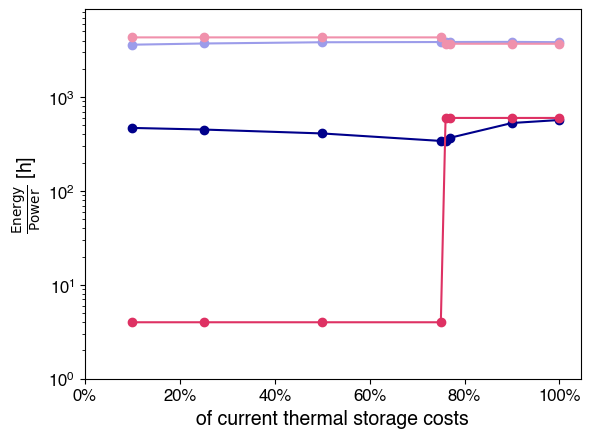

In [48]:
# Replace p with . in prices
prices_float = sorted([float(price.replace('p', '.')) for price in prices])

# Plot revenue per investment
plot_bars_maker_taker(prices_float, rev_per_inv, 'of current thermal storage costs', 
                      'Value added per investment [$/(\$ invested)]', 'Value added per Investment for BTES')
# Plot discharge_time
plot_bars_maker_taker(prices_float, discharge_time, 'of current thermal storage costs', 
                      r'$\frac{\mathrm{Energy}}{\mathrm{Power}}$ [h]', 'discharge_time for BTES',
                      y2=mean_discharge_time)


In [49]:
color_map = {
    'solar-utility': 'yellow',
    'solar-rooftop': 'lightgreen',
    'onwind': 'lightblue',
    'Lithium-Ion-LFP-bicharger': 'purple',
    'Lithium-Ion-LFP-bicharger % discharge': 'indigo',
    'Lithium-Ion-LFP-store': 'blue',
    'nuclear': 'orange',
    'CCGT': 'gray',
    'oil': 'black',
    'hydrogen storage underground': 'lightpink',
    'electrolysis': 'pink',
    'fuel cell': 'hotpink',
    'granite': 'red',
    'BTES_charger': 'darkred',
    'BTES_discharger': 'darkorange',
    'load': 'darkblue',
    'lost_load': 'darkgreen',
    'lost load': 'darkgreen',}

In [50]:
# Plot capacity for maker
def plot_capacity(prices, capacity, capacity_store):
    fig, ax = plt.subplots()
    # x axis in percent
    prices = [int(x*100) for x in prices]
    # Double y-axis
    ax2 = ax.twinx()
    ax.plot(prices, capacity['price_maker'], color=colors['price_maker'],
            linestyle=':', marker='o', label='Power capacity')
    ax.tick_params(axis='y', labelcolor=colors['price_maker'])
    # Scientific notation for y-axis
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    # Sey y range
    ax.set_ylim(0, 1.5*max(capacity['price_maker']))
    ax2.plot(prices, capacity_store['price_maker'], color='#87CEFA', 
             linestyle='-', marker='o', markerfacecolor='none', label='Energy capacity')
    ax2.tick_params(axis='y', labelcolor='#87CEFA')
    ax.set_xlabel('of current thermal storage costs', fontsize=14)
    ax.set_ylabel('Discharge capacity [MW]', color=colors['price_maker'], fontsize=14)
    ax2.set_ylabel('Energy capacity [MWh]', color='#87CEFA', fontsize=14)
    ax2.set_ylim(0, 1.5*max(capacity_store['price_maker']))
    # Add the labels in one legend
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
#     ax.legend(lines + lines2, labels + labels2, loc='upper right')
    # Axis tick labels size
    ax.tick_params(axis='x', labelsize=12)
    ax2.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    # Add % to x-axis tick labels
    ax.set_xticklabels([str(x) + '%' for x in [0, 20, 40, 60, 80, 100]])
    # Save figure
    plt.savefig('figures/btes_capacity_maker{0}.pdf'.format(case), bbox_inches='tight')

/tmp/ipykernel_1179377/2425895177.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(x) + '%' for x in [0, 20, 40, 60, 80, 100]])


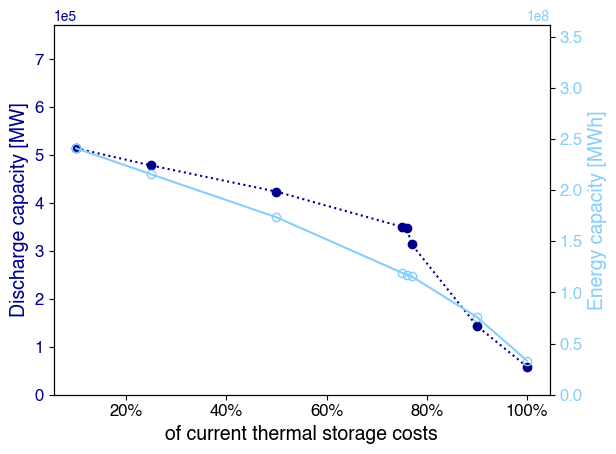

In [51]:
plot_capacity(prices_float, capacity, capacity_store)

In [52]:
def plot_all_capacities(prices, caps, color_map, store=False):
    fig, ax = plt.subplots()
    for i, cap in enumerate(caps['price_maker']):
        # Stacked bar chart
        for j, val in enumerate(cap.values):
            ax.bar(prices[i], val, bottom=sum(cap.values[:j]), label=cap.index[j], color=color_map[cap.index[j]])
    plt.xlabel('of current thermal storage costs')
    plt.ylabel('Optimal capacity [MW]')
    plt.ylim(0, max([sum(caps['price_maker'][i].values) for i in range(len(prices))])*1.1)
    # Only show each label once in legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1, 1))
    plt.savefig('figures/btes_capacity_all{0}.pdf'.format(case))

In [53]:
color_map = {
    'solar-utility': 'yellow',
    'solar-rooftop': 'lightgreen',
    'onwind': 'lightblue',
    'Lithium-Ion-LFP-bicharger': 'purple',
    'Lithium-Ion-LFP-bicharger % discharge': 'indigo',
    'Lithium-Ion-LFP-store': 'blue',
    'nuclear': 'orange',
    'CCGT': 'gray',
    'oil': 'black',
    'hydrogen storage underground': 'lightpink',
    'electrolysis': 'pink',
    'fuel cell': 'hotpink',
    'granite': 'red',
    'BTES_charger': 'darkred',
    'BTES_discharger': 'red',
    'load': 'darkblue',
    'lost_load': 'darkgreen',
    'lost load': 'darkgreen',}

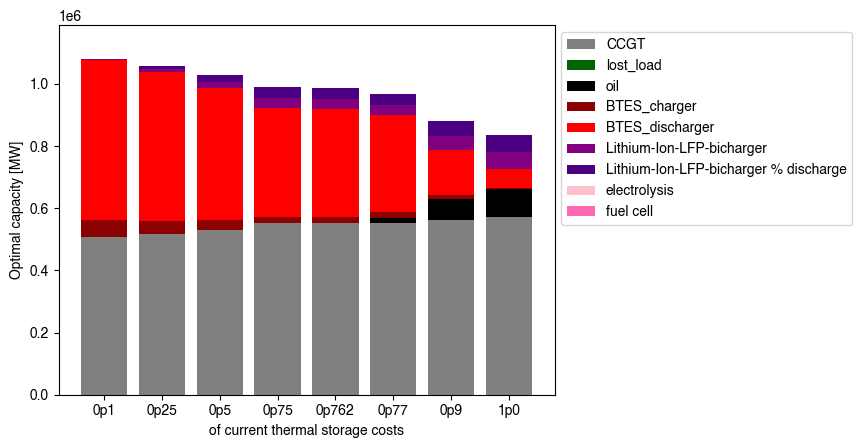

In [54]:
plot_all_capacities(prices, gen_capacity, color_map)